## Analysis of the topics created by the Top2Vec model

- Primitives are loaded, as well as the topic weights
- They are merged into one df, and value 1 is added to all values (resulting in a range of 0-2)
- Topics are plotted over time

**Issues**

- Every topic shows the same fluctuation graph over time, which might suggest that there are too many topics, or that the sum of the topic weights should be divided by the number of documents

**Solutions**

- Hierarchically reduce the number of topics in top2vec, using `hierarchical_topic_reduction(num topics)` --> see part II in `top2vec_training.ipynb`.
- Normalize for the nr of documents per time entity, using `agg.('mean)`.

In [1]:
import ndjson
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')


### Load primitives with corrected date and topic weights and merge both

In [85]:
# import primitives with corrected date and topic weights
with open('../../corpus/primitives_220331/events_repre_reduced.ndjson') as f:
    events = ndjson.load(f)

df_events = pd.DataFrame(events)
df_events.shape

(22721, 7)

In [86]:
# remove primitives that have no topic weights (shorter than 50 characters)

df_events.dropna(subset=['representation'], inplace=True)
df_events.shape

(19880, 7)

In [87]:
# transpose representations to 100 separate columns
representations = pd.DataFrame(df_events.representation.to_list(), index = df_events.index)

In [194]:
# merge events and representations

total = pd.merge(left=df_events, right=representations, left_index=True, right_index=True).drop(columns='representation')

### Plot dominant topics over time

In [195]:
total['year'] = total['clean_date'].str[:4]
total['year'] = pd.to_numeric(total['year'])
total = total[(total['year'] >= 1450) & (total['year'] <=1800)]

/tmp/ipykernel_223/2401015562.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total.groupby('year')[0, 1, 2, 3, 4].agg('mean').rolling(window=5).mean().plot()


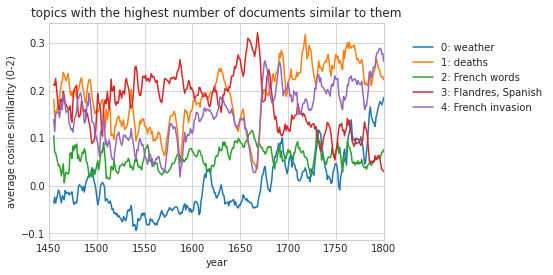

In [196]:
total.groupby('year')[0, 1, 2, 3, 4].agg('mean').rolling(window=5).mean().plot()
plt.legend(['0: weather', '1: deaths', '2: French words', '3: Flandres, Spanish', '4: French invasion'], loc='right', bbox_to_anchor=(1.5, 0.75))
plt.title('topics with the highest number of documents similar to them')
plt.ylabel('average cosine similarity (0-2)')
plt.xlabel('year')
plt.xlim([1450, 1800])
plt.show()

/tmp/ipykernel_223/1312611065.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total.groupby('year')[11, 41, 32, 20, 96].agg('mean').plot()


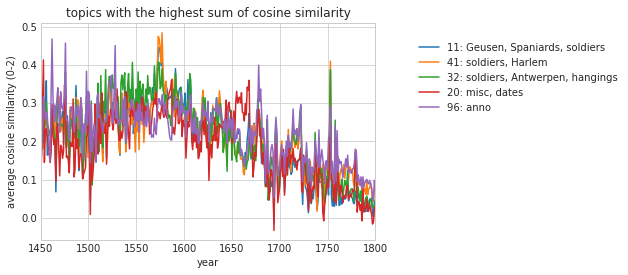

In [197]:
total.groupby('year')[11, 41, 32, 20, 96].agg('mean').plot()
# rolling(window=5).mean().plot()
plt.legend(['11: Geusen, Spaniards, soldiers', '41: soldiers, Harlem', '32: soldiers, Antwerpen, hangings', '20: misc, dates', '96: anno'], loc='right', bbox_to_anchor=(1.75, 0.75))
plt.title('topics with the highest sum of cosine similarity')
plt.ylabel('average cosine similarity (0-2)')
plt.xlabel('year')
plt.xlim([1450, 1800])
plt.show()

### Observations

- Difference between *topics with high number of documents similar to them* and *topics with high number of cosine similarity*
- What methods can we use to smoothen the signal?
    - `rolling(window).mean()` takes subsequent data points and averages them, but will give weird output when there are large time gaps between two data points.
    - `scipy.ndimage.gaussian_filter1d`, sigma = 2.

(1450.0, 1800.0)

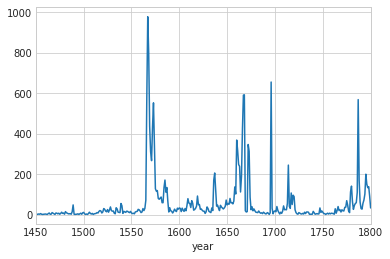

In [198]:
total.groupby('year')['year'].count().plot()
plt.xlim([1450, 1800])

### Scaling

- We use the original representations of the cosine similarity, ranging from -1 to +1.
- We apply the `TimeSeriesScalerMeanVariance` in `tslearn.preprocessing`.

In [210]:
columns = list(range(0,100))
year_mean = total.groupby('year')[columns].agg('mean').reset_index()

for column in year_avg:
- scale it with the TimeSeriesScalerMeanVariance
- save it as a np.array
- add it to a new scaled df

In [156]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaled = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform([topic3[3]])
topic3['scaled'] = scaled[0].flatten().tolist()
topic3.head()

(1450.0, 1800.0)

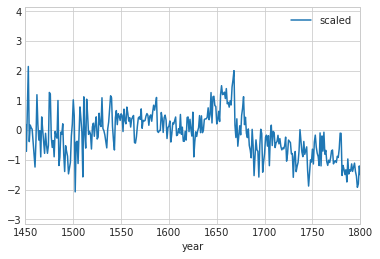

In [127]:
topic3.plot(x='year', y='scaled')
plt.xlim([1450, 1800])

### Smoothening with a Gaussian kernel

In [185]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter

In [161]:
years = topic3['year'].to_numpy()
topic = topic3['scaled'].to_numpy()
values = np.vstack([years, topic])

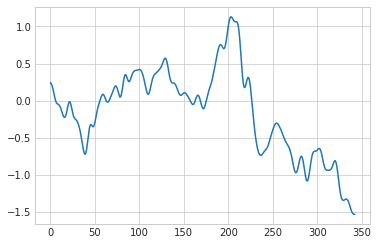

In [192]:
y3 = gaussian_filter1d(topic, 3)

plt.plot(y3)